# Exploratory analysis of 4 years of data of physics grades

In [1]:
!python -V #version of python

Python 3.6.5 :: Anaconda, Inc.


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('precision', 5)
import numpy as np
import re
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('tableau-colorblind10')

#### Read in .csv and remove blank columns

In [3]:
df = pd.read_csv("grades.csv")
print("physics course grade data read into dataframe successfully")
df.drop(['First day section','Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12'], axis=1, inplace=True)
df.rename(inplace=True, 
          index=str, 
          columns={
              "Identifier":"id",
              "Gndr_Flag":"gender",
              "Ethnicity":"ethnicity",
              "First Gen":"firstgen",
              "PHY 183 term":"term",
              "final grade":"grade",
              "Quarter term section":"section"
          }                             
)
df.head()

physics course grade data read into dataframe successfully


,id,gender,ethnicity,firstgen,term,section,grade
0,0080B044-2082-44C3-A6A1-A930DE7B456E,F,White (non-Hispanic),Y,FS14,2.0,1.5
1,008CEDE8-726D-46F8-BEE0-B99200BA8DBD,F,Black or African American (non-Hispanic),N,FS14,1.0,1.5
2,013133EC-45FB-4627-A436-79E547F5795E,M,International,Y,FS14,1.0,4.0
3,0131C37C-0336-4A9C-8988-CC605F5EE5A9,M,White (non-Hispanic),N,FS14,2.0,3.5
4,01A6F74B-7A75-4E4A-B012-9909E17EA743,F,White (non-Hispanic),N,FS14,4.0,3.5


In [4]:
df.shape

(6345, 7)

In [5]:
df['ethnicity'].value_counts()

White (non-Hispanic)                             3941
International                                    1193
Asian (non-Hispanic)                              443
Black or African American  (non-Hispanic)         304
Hispanic Ethnicity                                230
Two or more races (non-Hispanic)                  163
Not Reported                                       56
American Indian/Alaskan Native (non-Hispanic)       9
Hawaiian / Pacific Islander (non-Hispanic)          6
Name: ethnicity, dtype: int64

### Narrow to Domestic Students with reported ethnicity

#### We are interested in looking at the effect of a student's ethnicity on final course grade. We are also interested in only domestic students since this project is aimed at addressing the calls for a more diverse STEM workforce. 

#### 1. Remove all rows that are of students that have Ethnicity values of "International" or "Not Reported"

#### 2. Remove Hawaiian/Pacific Islander & American Indian/Alaskan Native since the N is so tiny

In [6]:
#data = data[data.Ethnicity != 'International']
#data = data[data.Ethnicity != 'Not Reported']

domestic = df.loc[
    (df.ethnicity != 'International') &
    (df.ethnicity != 'Not Reported') &
    (df.ethnicity != 'American Indian/Alaskan Native (non-Hispanic)') &
    (df.ethnicity != 'Hawaiian / Pacific Islander (non-Hispanic)')
].copy()

In [7]:
domestic['ethnicity'].value_counts()

White (non-Hispanic)                         3941
Asian (non-Hispanic)                          443
Black or African American  (non-Hispanic)     304
Hispanic Ethnicity                            230
Two or more races (non-Hispanic)              163
Name: ethnicity, dtype: int64

In [8]:
domestic.shape

(5081, 7)

### Separate students who received numeric grade (completed the course) and those that left the course (Dropped or Withdrawn)

In [9]:
receivedGrade = domestic.loc[
    (domestic['grade'] != '(dropped)') &
    (domestic['grade'] != 'W') &
    (domestic['grade'] != 'I') &
    (domestic['grade'] != 'V')   
].copy()
leftCourse = domestic.loc[
    (domestic['grade'] == '(dropped)') |
    (domestic['grade'] == 'W') 
].copy()

In [10]:
receivedGrade.dtypes
#we've removed all strings from this column
#now the 'final grade' column should be changed to dtype float
receivedGrade['grade'] = receivedGrade['grade'].astype(float)


***
# <font color=green> SUMMARY TABLES</font>
***

### Everyone who received a grade that is Domestic + Stated Ethnicity

In [11]:
receivedGrade['grade'].describe()

count    4763.00000
mean        2.99097
std         0.97174
min         0.00000
25%         2.50000
50%         3.00000
75%         3.50000
max         4.00000
Name: grade, dtype: float64

### Final grades grouped by Ethnicity

In [12]:
receivedGrade.groupby(['ethnicity'])['grade'].describe()

,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
Asian (non-Hispanic),418.0,2.94976,0.99513,0.0,2.5,3.0,3.5,4.0
Black or African American (non-Hispanic),269.0,2.25651,1.08638,0.0,1.5,2.5,3.0,4.0
Hispanic Ethnicity,210.0,2.55952,1.12392,0.0,2.0,3.0,3.5,4.0
Two or more races (non-Hispanic),156.0,2.94872,1.01787,0.0,2.5,3.0,3.5,4.0
White (non-Hispanic),3710.0,3.07507,0.91883,0.0,2.5,3.5,4.0,4.0


### Final grades grouped by Gender

In [13]:
receivedGrade.groupby(['gender'])['grade'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,1244.0,2.95619,0.97407,0.0,2.5,3.0,3.5,4.0
M,3519.0,3.00327,0.97075,0.0,2.5,3.0,3.5,4.0


### Final grades grouped by Gender+Ethnicity

In [14]:
receivedGrade.groupby(['ethnicity','gender'])['grade'].describe()

count     mean      std  \
ethnicity                                 gender                             
Asian (non-Hispanic)                      F        102.0  2.84314  1.06701   
                                          M        316.0  2.98418  0.97006   
Black or African American  (non-Hispanic) F         92.0  2.16304  1.13173   
                                          M        177.0  2.30508  1.06207   
Hispanic Ethnicity                        F         51.0  2.56863  0.91662   
                                          M        159.0  2.55660  1.18533   
Two or more races (non-Hispanic)          F         42.0  2.75000  1.04910   
                                          M        114.0  3.02193  1.00086   
White (non-Hispanic)                      F        957.0  3.07419  0.90254   
                                          M       2753.0  3.07537  0.92459   

                                                  min    25%  50%  75%  max  
ethnicity                                 gender                             
Asian (non-Hispanic)                      F       0.0  2.125  3.0  3.5  4.0  
                                          M       0.0  2.500  3.0  3.5  4.0  
Black or African American  (non-Hispanic) F       0.0  1.375  2.5  3.0  4.0  
                                          M       0.0  1.500  2.5  3.0  4.0  
Hispanic Ethnicity                        F       0.0  2.000  2.5  3.0  4.0  
                                          M       0.0  2.000  3.0  3.5  4.0  
Two or more races (non-Hispanic)          F       0.0  2.500  3.0  3.5  4.0  
                                          M       0.0  2.500  3.5  4.0  4.0  
White (non-Hispanic)                      F       0.0  2.500  3.5  3.5  4.0  
                                          M       0.0  2.500  3.5  4.0  4.0

### Final grades grouped by Gender+First Generation

In [15]:
receivedGrade.groupby(['ethnicity','firstgen'])['grade'].describe()

count     mean      std  \
ethnicity                                 firstgen                             
Asian (non-Hispanic)                      N          294.0  3.02041  0.96682   
                                          Y          124.0  2.78226  1.04423   
Black or African American  (non-Hispanic) N          174.0  2.32184  1.10693   
                                          Y           95.0  2.13684  1.04281   
Hispanic Ethnicity                        N          131.0  2.76336  1.03465   
                                          Y           79.0  2.22152  1.18956   
Two or more races (non-Hispanic)          N          120.0  2.98750  1.07387   
                                          Y           36.0  2.81944  0.80314   
White (non-Hispanic)                      N         3116.0  3.11280  0.90399   
                                          Y          594.0  2.87710  0.97007   

                                                    min    25%  50%  75%  max  
ethnicity                                 firstgen                             
Asian (non-Hispanic)                      N         0.0  2.500  3.0  4.0  4.0  
                                          Y         0.0  2.375  3.0  3.5  4.0  
Black or African American  (non-Hispanic) N         0.0  1.500  2.5  3.0  4.0  
                                          Y         0.0  1.500  2.5  3.0  4.0  
Hispanic Ethnicity                        N         0.0  2.500  3.0  3.5  4.0  
                                          Y         0.0  1.500  2.5  3.0  4.0  
Two or more races (non-Hispanic)          N         0.0  2.500  3.5  4.0  4.0  
                                          Y         1.0  2.000  3.0  3.5  4.0  
White (non-Hispanic)                      N         0.0  2.500  3.5  4.0  4.0  
                                          Y         0.0  2.500  3.0  3.5  4.0

***
# <font color=red>Histograms of distributions</font>

### grades by ethnicity

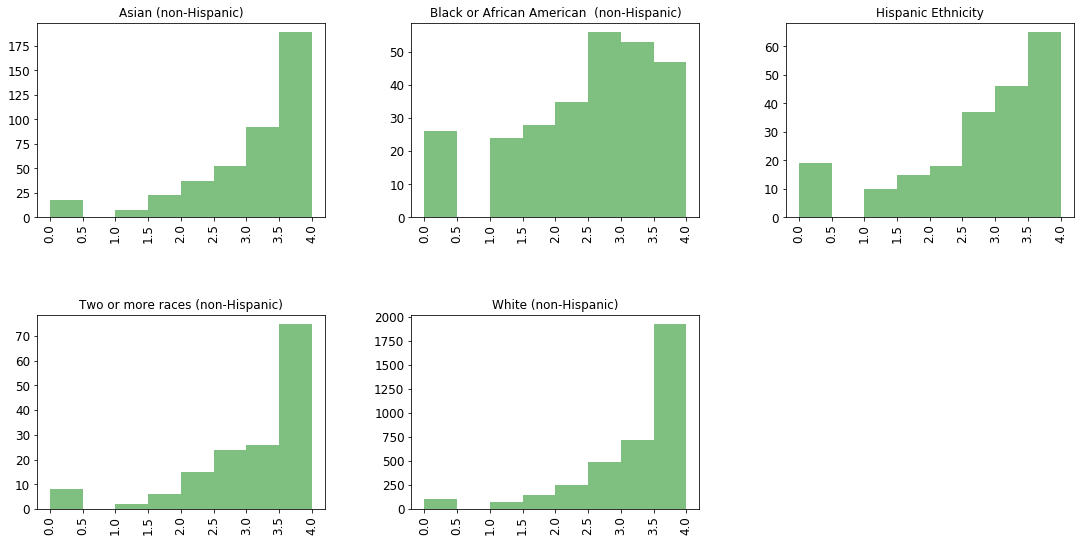

In [16]:
receivedGrade.hist(by='ethnicity', column='grade', 
                   figsize=(18,9), xrot=90, xlabelsize=12, 
                   ylabelsize=12, layout=(2,3), bins=(0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0), 
                   color=('green'), alpha=0.5);

### grades by gender

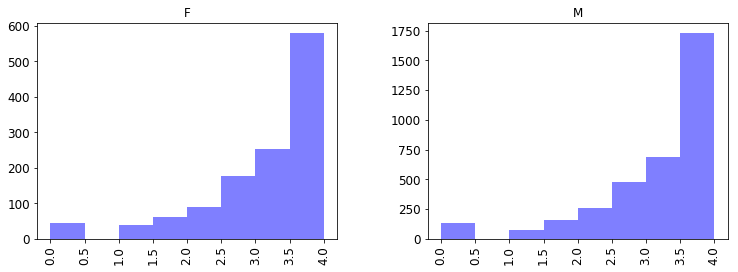

In [30]:
receivedGrade.hist(by='gender', column='grade', 
                   figsize=(12,4), xrot=90, xlabelsize=12, 
                   ylabelsize=12, layout=(1,2), bins=(0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0), 
                   color=('blue'), alpha=0.5);

### grades by first generation college status

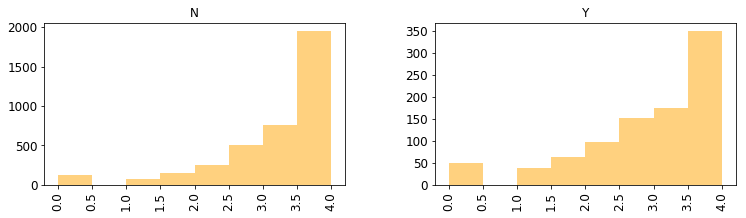

In [29]:
receivedGrade.hist(by='firstgen', column='grade', 
                   figsize=(12,3), xrot=90, xlabelsize=12, 
                   ylabelsize=12, layout=(1,2), bins=(0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0), 
                   color=('orange'), alpha=0.5);

### grades by term

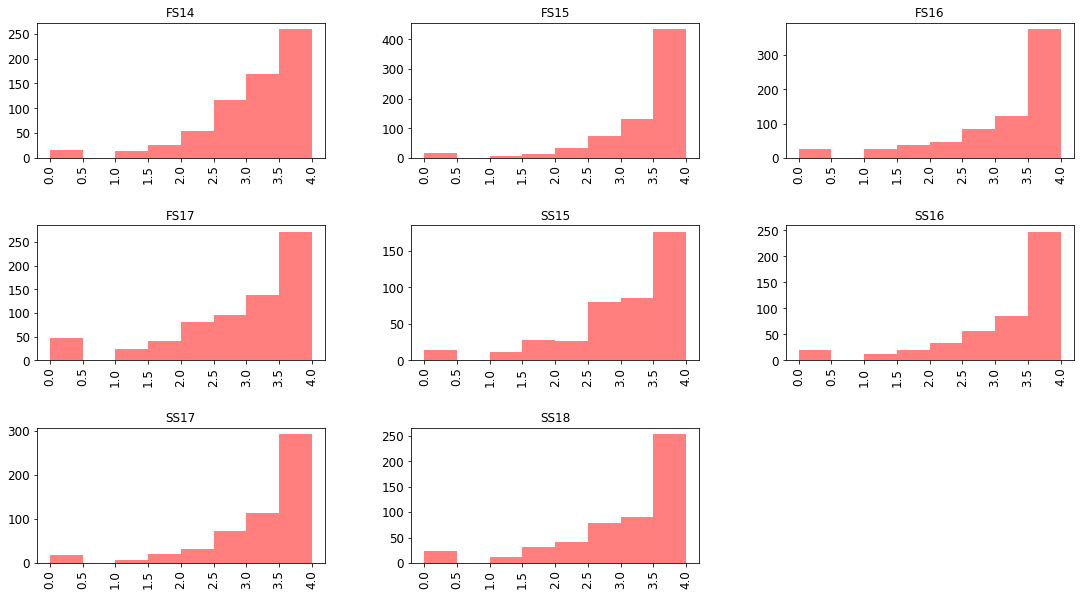

In [28]:
receivedGrade.hist(by='term', column='grade', 
                   figsize=(18,10), xrot=90, xlabelsize=12, 
                   ylabelsize=12, layout=(3,3), bins=(0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0), 
                   color=('red'), alpha=0.5);

***
# Plots with fraction of ethnicities in each grade range

In [20]:
conditions = [
                (receivedGrade['grade']<=1.5),
                (receivedGrade['grade']>=2.0) & (receivedGrade['grade']<3.0),
                (receivedGrade['grade']>=3.0)
]
choices = ['(0.0-1.5)','(2.0-2.5)','(3.0-4.0)']
receivedGrade['gradeCategory'] = np.select(conditions, choices, default=False)

InGradeCategory = receivedGrade.groupby(['gradeCategory','ethnicity'])['grade'].count().unstack()
totalInEthnicity = receivedGrade.groupby(['ethnicity'])['grade'].count().head()

for i in range(0,5):
    InGradeCategory.iloc[:,i] = InGradeCategory.iloc[:,i]/totalInEthnicity.iloc[i]
InGradeCategory

ethnicity,Asian (non-Hispanic),Black or African American (non-Hispanic),Hispanic Ethnicity,Two or more races (non-Hispanic),White (non-Hispanic)
gradeCategory,,,,,
(0.0-1.5),0.11483,0.28996,0.20952,0.10256,0.08733
(2.0-2.5),0.21292,0.33829,0.26190,0.25000,0.19784
(3.0-4.0),0.67225,0.37175,0.52857,0.64744,0.71482


Text(0,0.5,'Fraction of Ethnicity Group')

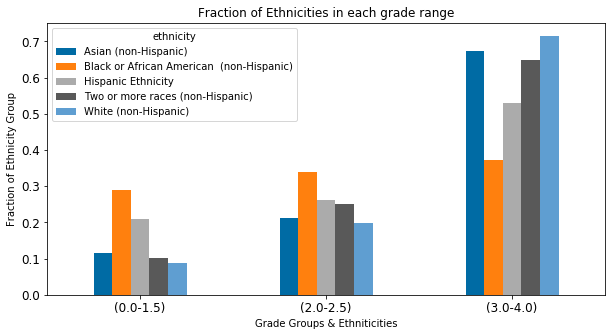

In [21]:
ax = InGradeCategory.plot(kind='bar',
            title='Fraction of Ethnicities in each grade range',
            fontsize=12, rot=0,figsize=(10,5))
ax.set_xlabel('Grade Groups & Ethniticities')
ax.set_ylabel('Fraction of Ethnicity Group')


In [22]:
receivedGrade.groupby(['gradeCategory','ethnicity'])['grade'].count().head()

gradeCategory  ethnicity                                
(0.0-1.5)      Asian (non-Hispanic)                          48
               Black or African American  (non-Hispanic)     78
               Hispanic Ethnicity                            44
               Two or more races (non-Hispanic)              16
               White (non-Hispanic)                         324
Name: grade, dtype: int64

In [23]:
receivedGrade.groupby(['ethnicity'])['grade'].count()

ethnicity
Asian (non-Hispanic)                          418
Black or African American  (non-Hispanic)     269
Hispanic Ethnicity                            210
Two or more races (non-Hispanic)              156
White (non-Hispanic)                         3710
Name: grade, dtype: int64

# Older uglier plots

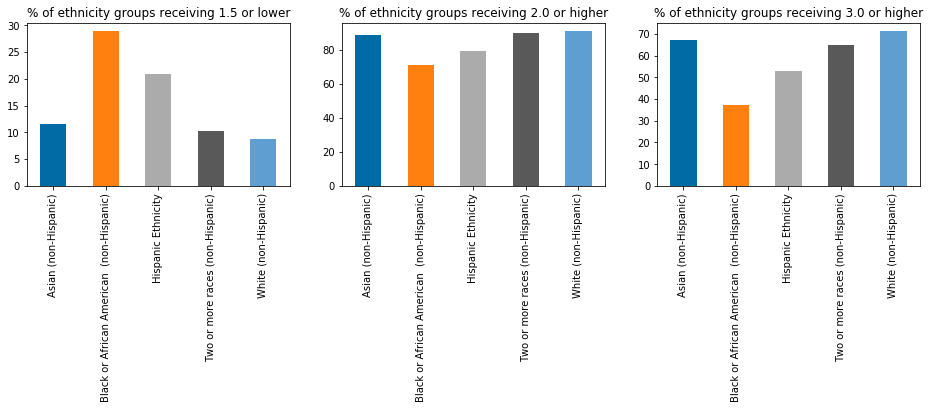

In [31]:
underMinimum = receivedGrade.loc[ receivedGrade["grade"] <= 1.5 ].copy()
aboveMinimum = receivedGrade.loc[ receivedGrade["grade"] >= 2.0 ].copy()
threeAndAbove = receivedGrade.loc[ receivedGrade["grade"] >= 3.0 ].copy()

underMinimumByEthnicity = 100*underMinimum['ethnicity'].value_counts()/receivedGrade['ethnicity'].value_counts()
aboveMinimumByEthnicity = 100*aboveMinimum['ethnicity'].value_counts()/receivedGrade['ethnicity'].value_counts()
threeAndAboveByEthnicity = 100*threeAndAbove['ethnicity'].value_counts()/receivedGrade['ethnicity'].value_counts()
underMinimumByEthnicity = underMinimumByEthnicity.sort_index()
aboveMinimumByEthnicity = aboveMinimumByEthnicity.sort_index()
threeAndAboveByEthnicity = threeAndAboveByEthnicity.sort_index()

fig=plt.figure(figsize=(16, 3))
fig.add_subplot(131)
underMinimumByEthnicity.plot.bar(
    title="% of ethnicity groups receiving 1.5 or lower", 
    )
fig.add_subplot(132)
aboveMinimumByEthnicity.plot.bar(title="% of ethnicity groups receiving 2.0 or higher")
fig.add_subplot(133)
threeAndAboveByEthnicity.plot.bar(title="% of ethnicity groups receiving 3.0 or higher")
plt.show()

***
# TESTS FOR SIGNIFICANCE

### (Comparing Distributions) Mann-Whitney-Wilcoxon (MWW) RankSums

In [25]:
z_stat, p_val = stats.ranksums(
    receivedGrade.loc[receivedGrade['ethnicity'] == 'White (non-Hispanic)']['grade'],
    receivedGrade.loc[receivedGrade['ethnicity'] == 'Black or African American  (non-Hispanic)']['grade']
)
receivedGrade.loc[receivedGrade['ethnicity'] == 'White (non-Hispanic)']['grade'].mean()
receivedGrade.loc[receivedGrade['ethnicity'] == 'Black or African American  (non-Hispanic)']['grade'].mean()

print("Comparing grade distributions of White and Black students p =", format(p_val, '.9f'))


z_stat, p_val = stats.ranksums(
    receivedGrade.loc[receivedGrade['ethnicity'] == 'White (non-Hispanic)']['grade'],
    receivedGrade.loc[receivedGrade['ethnicity'] == 'Asian (non-Hispanic)']['grade']
)
print("Comparing grade distributions of White and Asian students p =", format(p_val, '.9f'))


z_stat, p_val = stats.ranksums(
    receivedGrade.loc[receivedGrade['ethnicity'] == 'White (non-Hispanic)']['grade'],
    receivedGrade.loc[receivedGrade['ethnicity'] == 'Hispanic Ethnicity']['grade']
)
print("Comparing grade distributions of White and Hispanic students p =", format(p_val, '.9f'))


z_stat, p_val = stats.ranksums(
    receivedGrade.loc[receivedGrade['ethnicity'] == 'White (non-Hispanic)']['grade'],
    receivedGrade.loc[receivedGrade['ethnicity'] == 'Two or more races (non-Hispanic)']['grade']
)
print("Comparing grade distributions of White and Multiracial students p =",format(p_val,'.9f'))

Comparing grade distributions of White and Black students p = 0.000000000
Comparing grade distributions of White and Asian students p = 0.018006612
Comparing grade distributions of White and Hispanic students p = 0.000000000
Comparing grade distributions of White and Multiracial students p = 0.167840284


***
# Cliff's Delta Calculation

### https://github.com/neilernst/cliffsDelta

In [32]:
from __future__ import division

def cliffsDelta(lst1, lst2, **dull):

    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d, size

def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'

def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two


### Cliff's Delta for White & Black Students

In [36]:
d, size = cliffsDelta(receivedGrade.loc[receivedGrade['ethnicity'] == 'White (non-Hispanic)']['grade'],
                     receivedGrade.loc[receivedGrade['ethnicity'] == 'Black or African American  (non-Hispanic)']['grade']
                     )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)


Cliff's Delta= 0.461105823
Effect Size= medium


### Cliff's Delta for White & Hispanic Students

In [38]:
d, size = cliffsDelta(receivedGrade.loc[receivedGrade['ethnicity'] == 'White (non-Hispanic)']['grade'],
                     receivedGrade.loc[receivedGrade['ethnicity'] == 'Hispanic Ethnicity']['grade']
                     )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)

Cliff's Delta= 0.287036324
Effect Size= small


### Cliff's Delta for WhiteFemale & HispanicFemale

In [41]:
d, size = cliffsDelta(
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'White (non-Hispanic)') & 
    (receivedGrade['gender'] == 'F')]['grade'],
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'Hispanic Ethnicity') &
    (receivedGrade['gender'] == 'F')]['grade']     
    )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)

Cliff's Delta= 0.354293442
Effect Size= medium


### Cliff's Delta for WhiteFemale & BlackFemale <font color=red>LARGE EFFECT</font>

In [42]:
d, size = cliffsDelta(
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'White (non-Hispanic)') & 
    (receivedGrade['gender'] == 'F')]['grade'],
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'Black or African American  (non-Hispanic)') &
    (receivedGrade['gender'] == 'F')]['grade']     
    )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)

Cliff's Delta= 0.488835128
Effect Size= large


### Cliff's Delta for WhiteMale & HispanicMale

In [45]:
d, size = cliffsDelta(
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'White (non-Hispanic)') & 
    (receivedGrade['gender'] == 'M')]['grade'],
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'Hispanic Ethnicity') &
    (receivedGrade['gender'] == 'M')]['grade']     
    )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)

Cliff's Delta= 0.266159044
Effect Size= small


### Cliff's Delta for WhiteMale & BlackMale

In [46]:
d, size = cliffsDelta(
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'White (non-Hispanic)') & 
    (receivedGrade['gender'] == 'M')]['grade'],
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'Black or African American  (non-Hispanic)') &
    (receivedGrade['gender'] == 'M')]['grade']     
    )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)

Cliff's Delta= 0.447089051
Effect Size= medium


### Cliff's Delta for WhiteFirstGeneration & BlackFirstGeneration

In [47]:
d, size = cliffsDelta(
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'White (non-Hispanic)') & 
    (receivedGrade['firstgen'] == 'Y')]['grade'],
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'Black or African American  (non-Hispanic)') &
    (receivedGrade['firstgen'] == 'Y')]['grade']     
    )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)

Cliff's Delta= 0.422505759
Effect Size= medium


### Cliff's Delta for WhiteFirstGeneration & HispanicFirstGeneration

In [48]:
d, size = cliffsDelta(
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'White (non-Hispanic)') & 
    (receivedGrade['firstgen'] == 'Y')]['grade'],
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'Hispanic Ethnicity') &
    (receivedGrade['firstgen'] == 'Y')]['grade']     
    )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)

Cliff's Delta= 0.329156544
Effect Size= small


### Cliff's Delta for WhiteFirstGenerationFemale & BlackFirstGenerationFemale <font color=red>LARGE EFFECT</font>

In [53]:
d, size = cliffsDelta(
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'White (non-Hispanic)') & 
    (receivedGrade['gender'] == 'F') &
    (receivedGrade['firstgen'] == 'Y')]['grade'],
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'Black or African American  (non-Hispanic)') &
    (receivedGrade['gender'] == 'F') &
    (receivedGrade['firstgen'] == 'Y')]['grade']     
    )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)

Cliff's Delta= 0.487899125
Effect Size= large


### Cliff's Delta for WhiteFirstGenerationFemale & HispanicFirstGenerationFemale <font color=red>LARGE EFFECT</font>

In [55]:
d, size = cliffsDelta(
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'White (non-Hispanic)') & 
    (receivedGrade['gender'] == 'F') &
    (receivedGrade['firstgen'] == 'Y')]['grade'],
    receivedGrade.loc[
    (receivedGrade['ethnicity'] == 'Hispanic Ethnicity') &
    (receivedGrade['gender'] == 'F') &
    (receivedGrade['firstgen'] == 'Y')]['grade']     
    )
print("Cliff's Delta=",format(d,'.9f'))
print("Effect Size=",size)

Cliff's Delta= 0.507382550
Effect Size= large
